In [54]:
#imports go here

from sage.plot.polygon import Polygon
from sage.plot.colors import rainbow

In [202]:
"""
There are two problems we want to solve:
1) How large of a supertile must we compute to find all of the 1-collared prototiles?
2) How can we generate all of the 1-collared prototiles from a large enough subsection of the tiling?

Also, we want to be able to do this for other types of tilings, not just those that use vertical/horizontal
lines to construct the prototiles. For instance, https://tilings.math.uni-bielefeld.de/substitution/binary/
uses rhombuses with internal angles either in {pi/5, 3pi/5} or {2pi/5, 4pi/5}

For now, the focus will be on representing tilings as a collection of objects rather than as a graphics
object, as this will save computing power and the resulting collections can just be graphed after being
generated. Once we can generate large supertile objects, we can start to write functions that generate
the possible collars of a set of prototiles.
"""

# This lets us not have to create a new matrix object every time we need to do a rotation.
# Just index into the dictionary with the angle you need to rotate by.

rot = {
    0 : matrix(2,2,[cos(0),-sin(0),sin(0),cos(0)]),
    pi/2 : matrix(2,2,[cos(pi/2),-sin(pi/2),sin(pi/2),cos(pi/2)]),
    pi: matrix(2,2,[cos(pi),-sin(pi),sin(pi),cos(pi)]),
    3*pi/2 : matrix(2,2,[cos(3*pi/2),-sin(3*pi/2),sin(3*pi/2),cos(3*pi/2)])
}

# Calculates theta mod 2pi, assuming theta is in the range [0, 4pi)
def mod_2pi (theta):
    if theta >= 2*pi:
        return theta - 2*pi
    return theta

# We keep a dictionary for the supertile, where each key-value pair is given as:
# {point : prototiles}
# where point is a vertex of some prototile in the supertile and prototiles is
# a list of the tiles which share that vertex. This will make it easier to search
# for prototiles given a vertex, since lookup in a dictionary is constant-time and
# the list of prototiles will only be of size 4, at most.
vert_map = {}

class ChairTile:
    
    # We define a supertile by:
    # level, i.e. n where the supertile is L_n
    # orientation as a multiple of pi describing rotation around its center
    # origin, describing where to place this tile when moving up a level. The origin is the point that stays fixed
    #     when moving up a level.
    def __init__(self, level: int, orientation, origin: vector):
        self.points = []
        self.level = level
        self.orientation = mod_2pi(orientation)
        self.origin = origin

        if (level < 0):
            raise Exception("Level must be a non-negative integer.")

        #TODO: Add 2 extra vertices for between the long ends, to make it clearer
        if (level == 0):
            self.points = [vector((0 + origin[0], 0 + origin[1])),
                           vector((1 + origin[0], 0 + origin[1])),
                           vector((2 + origin[0], 0 + origin[1])), 
                           vector((2 + origin[0], 1 + origin[1])), 
                           vector((1 + origin[0], 1 + origin[1])), 
                           vector((1 + origin[0], 2 + origin[1])), 
                           vector((0 + origin[0], 2 + origin[1])),
                           vector((0 + origin[0], 1 + origin[1]))]
            self.center = rot[self.orientation] * vector((1, 1)) + origin
            self.rotate_tile(origin, rot[self.orientation])

            for p in self.points:
                l = tuple(p)
                if vert_map.get(l):
                    vert_map[l].append(self)
                else:
                    vert_map[l] = [self]

        else:
            # If this is a supertile, we consider it to be the collection of all the prototiles that make it up
            self.subtiles = list()
            st_1 = ChairTile(level - 1, self.orientation, origin)
            st_2 = ChairTile(level - 1, self.orientation, origin + rot[self.orientation]*vector((2**(level - 1), 2**(level - 1))))
            st_3 = ChairTile(level - 1, self.orientation + pi/2, origin + rot[self.orientation]*vector((2** (level + 1), 0)))
            st_4 = ChairTile(level - 1, self.orientation + 3*pi/2, origin + rot[self.orientation]*vector((0, 2** (level + 1))))
            
            self.subtiles.append(st_1)
            self.subtiles.append(st_2)
            self.subtiles.append(st_3)
            self.subtiles.append(st_4)

        

    # Rotates a tile around a point, where mat is the rotation matrix for the degree of rotation
    def rotate_tile(self, center, mat):
        if self.level == 0:
            pts = [mat*vector((p[0]-center[0],p[1]-center[1])) for p in self.points]
            self.points = [(p[0]+center[0],p[1]+center[1]) for p in pts]
        else:
            for c in self.subtiles:
                c.rotate_tile(center, mat)

    # Display a tile, graphically. Useful for bug-fixing and testing.
    def show_tile(self):
        show(polygon(self.points, fill=false, xmin=0, ymin=0, xmax=16, ymax=16))


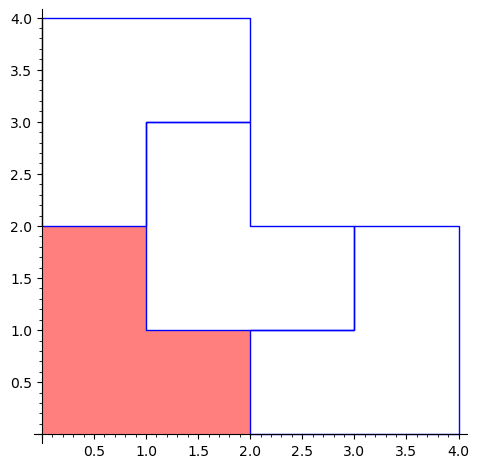

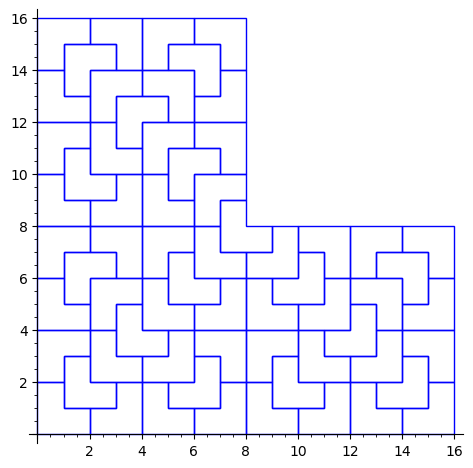

In [224]:
# Use this for testing if the tiling 'looks' right. We shouldn't be using graphics for actually
# doing any work with a tile object. 

vert_map = {}
p = ChairTile(3, 0, vector((0,0)))

# Displays a supertile s graphically
def display_tiles(s):
    G = Graphics()
    if s.level == 0:
        return polygon(s.points, fill=false)
    else:
        for c in s.subtiles:
            G += display_tiles(c)
    return G

# Displays all neighbors of all prototiles in p. Does make a lot of repeats, so 
# can certainly be optimized. 
for k in vert_map.keys():
    patch = Patch()
    s1 = vert_map[k][0]
    s = find_neighbors(p, vert_map[k][0])
    for t in s:
        patch.add_tile(t)
    patch.display_patch(s1)
    break
        
show(display_tiles(p))

In [223]:
# We want to form a list of 1-collars for the chair tile. We can use symmetry and the boundary
# trick to do this until we find the known limit of 56 1-collars. Specifically, we want to
# generate larger and larger supertiles and find which new collars appear on the boundary 
# between the old supertile and the new one. Then, we find the neighbors of those tiles, and 
# add them to a set of all 1-collars, until we find 56.

# A patch represents a group of tiles. Specifically, we want one to represent a group of tiles
# which are all neighboring, and which form an n-collar of the central tile. 
class Patch:
    def __init__ (self):
        self.tiles = set()

    def add_tile(self, tile):
        self.tiles.add(tile)

    # Displays the patch graphically, with tile marked in red.
    def display_patch (self, tile=None):
        G = Graphics()
        for t in self.tiles:
            if (t == tile):
                G += polygon(t.points, fill=true, rgbcolor=(1,0,0), alpha=0.5)
            else:
                G += polygon(t.points, fill=false)
        show(G)

# TODO: Represent supertiles as graphs, where prototiles are vertices and edges are neighbor relationships
# Then, we can find neighbors-of-neighbors by squaring the adjacency matrix.
# To identify interior vertices, look for endpoints of edges that are only connected to one prototile

# Finds the neighbors of the prototile p_tiles, out of the prototiles present in s_tile.
# Returns a list of prototiles that represents the neigbors of each p_tile. We just use vert_map
# to find all prototiles that share a vertex with p_tile.
def find_neighbors(s_tile: ChairTile, p_tile):
    neighborhood = set()
    for p in p_tile.points:
        for t in vert_map[p]:
            neighborhood.add(t)

    return neighborhood